In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
import cv2

In [3]:
RANDOM_SEED = 56

In [4]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv") 

In [5]:
img_path = 'images/'
images_path = os.path.join("dataset/"+img_path) #declaring file path

In [6]:
image_filenames = list(os.listdir(images_path)) 

## Data Processing :-

In [7]:
def train_data_prep(df,images_path):
    training_images,train_labels = [],[]
    
    for image in tqdm(df['image_names']):
        img = cv2.imread(images_path+image)
        img = cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)
        
        training_images.append(img)
        
        labels = df.loc[df['image_names']==image,'emergency_or_not'].values[0]
        train_labels.append(labels)
        
    return np.array(training_images),train_labels    # images are returned as a numpy array because there is requirement of changing dimension further in the code

In [8]:
def test_data_prep(df,images_path):
    test_images = []
    
    for image in tqdm(df['image_names']):
        img = cv2.imread(images_path+image)
        img = cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)
        
        test_images.append(img)
    
    return np.array(test_images)     #images are returned as a numpy array because there is requirement of changing dimension further in the code

In [9]:
train_images,train_labels = train_data_prep(train_df,images_path)

100%|█████████████████████████████████████████████████████████████████████████████| 1646/1646 [00:04<00:00, 381.65it/s]


In [10]:
test_images = test_data_prep(test_df,images_path)

100%|███████████████████████████████████████████████████████████████████████████████| 706/706 [00:01<00:00, 470.06it/s]


In [11]:
print(len(train_images))
print(len(test_images))

1646
706


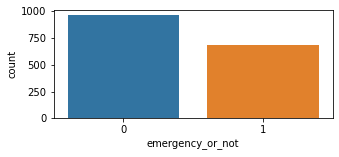

In [12]:
plt.figure(figsize=(5,2))
sns.countplot(train_df['emergency_or_not'])

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
#train_labels = to_categorical(train_labels,2)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.1,random_state=RANDOM_SEED,stratify=train_labels)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  shear_range=0.4,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  zoom_range=0.3,
                                  brightness_range = [0.2,1],
                                  fill_mode='nearest'
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_datagen.fit(x_train)
test_datagen.fit(test_images)
test_datagen.fit(x_val)

In [20]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(test_images)

In [21]:
batchsize=15

In [22]:
train_set = train_datagen.flow(x_train,
                              to_categorical(y_train,2),
                              batch_size=batchsize)
val_set = test_datagen.flow(x_val,
                            to_categorical(y_val,2),
                            batch_size=7)

In [23]:
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications import VGG16,ResNet50V2,InceptionV3

In [ ]:
'''model_tl = VGG16(include_top=False,
                     pooling=None,
                     weights='imagenet',
                     input_shape=(224,224,3))
model_tl.trainable = False'''

## Functional API Approach :-

In [ ]:
'''x = model_tl.output
l1 = Flatten()(x)
l2 = Dense(512,activation='relu')(l1)
l3 = Dropout(0.4)(l2)
l3 = Dense(256,activation='relu')(l2)
l4 = BatchNormalization()(l3)
l5 = Dropout(0.4)(l4)
l6 = Dense(64,activation='relu')(l5)
l7 = BatchNormalization()(l6)
out = Dense(2,activation='sigmoid')(l7)

model_fapi = Model(inputs=model_tl.input,outputs=out)
model_fapi.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_fapi.summary()'''

In [24]:
model_fapi = load_model('Models/final_model.h5')

In [44]:
callback = [ModelCheckpoint('tmp_weights/epochs_{epoch:02d}_acc_{val_accuracy:0.4f}',
                           save_best_only=True,
                           save_weights_only=True,
                           monitor='val_loss'),
           EarlyStopping(patience=2,
                        monitor='val_accuracy'),
           PlotLossesKeras()]

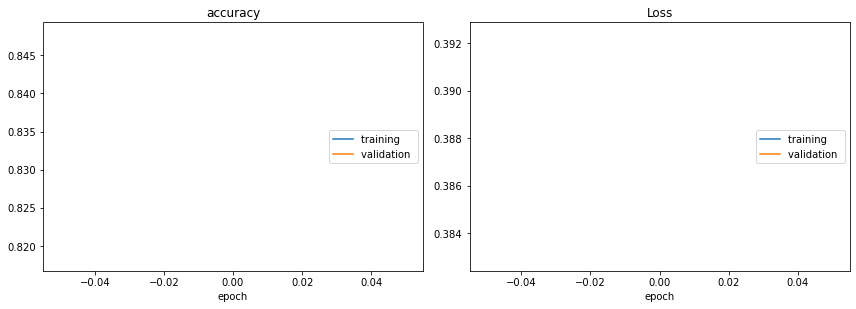

accuracy
	training         	 (min:    0.818, max:    0.818, cur:    0.818)
	validation       	 (min:    0.848, max:    0.848, cur:    0.848)
Loss
	training         	 (min:    0.392, max:    0.392, cur:    0.392)
	validation       	 (min:    0.383, max:    0.383, cur:    0.383)
98/98 [==============================] - 443s 5s/step - loss: 0.3919 - accuracy: 0.8182 - val_loss: 0.3829 - val_accuracy: 0.8478


In [45]:
h = model_fapi.fit_generator(train_set,
                            validation_data=val_set,
                            steps_per_epoch=train_set.n//batchsize,
                            validation_steps=val_set.n//7,
                            epochs=1,
                            callbacks=callback)

## For Evaluation Purposes :-

In [46]:
y_pred = model_fapi.predict(x_test)

In [47]:
y_pred = [np.argmax(i) for i in y_pred]

In [48]:
sub = pd.DataFrame({'image_names':test_df.image_names,'emergency_or_not':y_pred})
sub.to_csv("Submission.csv",index=False)

## Model Save :-

In [49]:
model_fapi_json = model_fapi.to_json()
with open("Models/final_model_fapi.json",'w') as file:
    file.write(model_fapi_json)

In [50]:
model_fapi.save("Models/final_model.h5")